In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -av "/content/drive/MyDrive/SIV Project Data" "/content/Project Data"

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def fillmissing(data):
    for col in data.columns:
        if data[col].isna().sum() > 0:
            data[col].fillna(0, inplace=True)
    return data

def encode(data, columns_list):
    data = pd.get_dummies(data, columns = columns_list)
    return data

def drop_columns(data, columns_list):
    data = data.drop(columns_list, axis = 1)
    return data

def binarize_columns(data, columns_list):
    for col in columns_list:
        data[col] = data[col].astype(int)
    return data

def generate_ip_attribute(data):
    temp = data['ip'].apply(lambda x: ".".join(x.split('.')[:1]))
    vc = temp.value_counts()
    data['ip'] = temp.apply(lambda x: x if vc[x]>150 else "other")
    return data

def class_resampling(X, y):
    from imblearn.over_sampling import RandomOverSampler

    ros = RandomOverSampler(random_state=42)

    # fit predictor and target variable
    x_ros, y_ros = ros.fit_resample(X, y)

    return x_ros, y_ros

train_data = pd.read_csv('./cybersecurity_training.csv', delimiter="|", header=[0])

train_data = fillmissing(train_data)

# for col in train_data.columns:
#     print(col, train_data[col].dtype)

binary_columns_list = [ 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10']
useless_columns_list = ['client_code', 'alert_ids']
one_hot_encode_columns_list = ['ip', 'categoryname', 'ipcategory_name', 'ipcategory_scope', 'parent_category', 'grandparent_category', 'weekday', 'dstipcategory_dominate', 'srcipcategory_dominate']

# Adding new attribute ip_prefix
train_data = generate_ip_attribute(train_data)

train_data = encode(train_data, one_hot_encode_columns_list)
train_data = drop_columns(train_data, useless_columns_list)
train_data = binarize_columns(train_data, binary_columns_list)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


ROC AUC score 0.732927
Average precision score 0.131071
Mean Squared error 0.088173
Macro F1 score 0.548249
Micro F1 score 0.911827


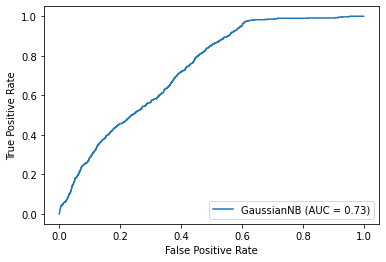

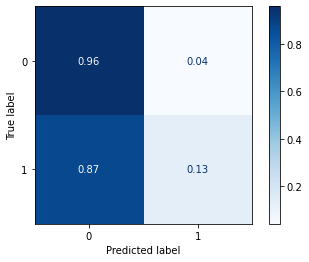

In [ ]:
###   Naive Bayes

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

y = train_data['notified']
X = train_data.drop('notified', axis=1)
test_split_size = 0.3
seed = 1011

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split_size, random_state=1010, shuffle=True, stratify = y)

X_train, y_train = class_resampling(X_train, y_train)

model = GaussianNB()
model.fit(X_train,y_train)


predictions = model.predict_proba(X_test)
y_pred = model.predict(X_test)

print("ROC AUC score", round(metrics.roc_auc_score(y_test, predictions[:,1]),6))
print("Average precision score", round(metrics.average_precision_score(y_test, predictions[:,1]),6))

print("Mean Squared error", round(metrics.mean_squared_error(y_test, y_pred),6))
print("Macro F1 score", round(metrics.f1_score(y_test, y_pred, average='macro'),6))
print("Micro F1 score", round(metrics.f1_score(y_test, y_pred, average='micro'),6))

metrics.plot_roc_curve(model, X_test, y_test)  
plt.savefig("nb_roc.png") 

metrics.plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize='true')  
plt.savefig("nb_confussion.png")
